# Machine Learning - TP3

Dans ce troisième TP, vous allez utiliser la librairie [Scikit-learn]() ainsi que les algorithmes vus en cours pour résoudre différents problèmes. Les compétences du précédent TP (EDA, nettoyage et encodage des données) seront à nouveau nécessaires !

Une grande marque d'hypermarchés souhaite analyser les *patterns* d'achats de ses clients, et regrouper les clients selon leurs habitudes. L'objectif est, à terme, de faire des campagnes marketings ciblées pour chacun de ces groupes. Pour l'instant, on ne sait même pas quels groupes de clients existent (c'est-à-dire quelles habitudes).

<details>
<summary>Description des colonnes</summary>

| Colonne | Description |
|---------|-------------|
| ID | Customer's unique identifier |
| Year_Birth | Customer's birth year |
| Education | Customer's education level |
| Marital_Status | Customer's marital status |
| Income | Customer's yearly household income |
| Kidhome | Number of children in customer's household |
| Teenhome | Number of teenagers in customer's household |
| Dt_Customer | Date of customer's enrollment with the company |
| Recency | Number of days since customer's last purchase |
| Complain | 1 if the customer complained in the last 2 years, 0 otherwise |
| MntWines | Amount spent on wine in last 2 years |
| MntFruits | Amount spent on fruits in last 2 years |
| MntMeatProducts | Amount spent on meat in last 2 years |
| MntFishProducts | Amount spent on fish in last 2 years |
| MntSweetProducts | Amount spent on sweets in last 2 years |
| MntGoldProds | Amount spent on gold in last 2 years |
| NumDealsPurchases | Number of purchases made with a discount |
| AcceptedCmp1 | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| AcceptedCmp2 | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| AcceptedCmp3 | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| AcceptedCmp4 | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| AcceptedCmp5 | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| Response | 1 if customer accepted the offer in the last campaign, 0 otherwise |
| NumWebPurchases | Number of purchases made through the company’s website |
| NumCatalogPurchases | Number of purchases made using a catalogue |
| NumStorePurchases | Number of purchases made directly in stores |
| NumWebVisitsMonth | Number of visits to company’s website in the last month |

</details>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set()

## Exercice 1 : Clustering de personnalités de clients

Pour répondre au problème posé, nous allons faire du *clustering* pour identifier ces habitudes et regrouper les clients par *clusters*.

Q1. Chargez les données du fichier `marketing_campaign.csv` dans un DataFrame `df_customers`.

In [41]:
# Charger les fichiers CSV en séparant les données par des points-virgules
df_customers = pd.read_csv("marketing_campaign.csv", sep='\t')

# Afficher un résumé statistique des données
print(df_customers.describe())

# Afficher les types de données et vérifier les valeurs manquantes
print(df_customers.info())

                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000  

Q2. Où sont les données manquantes ? Ne les supprimez pas pour l'instant.

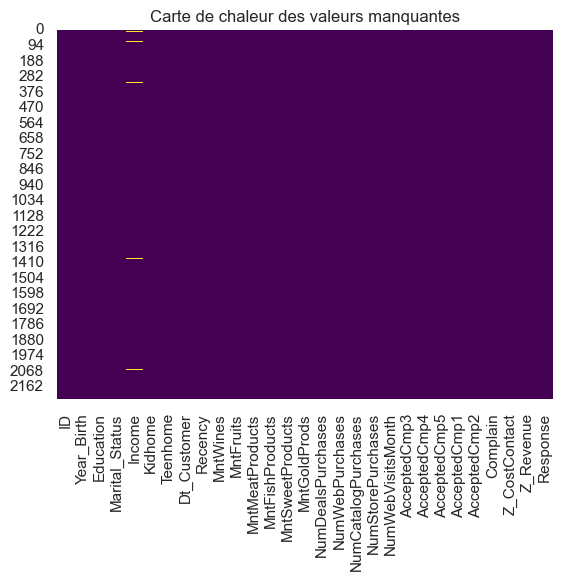

In [42]:
sns.heatmap(df_customers.isnull(), cbar=False, cmap='viridis')
plt.title('Carte de chaleur des valeurs manquantes')
plt.show()

# On remarque qu'il y a des données manquantes dans la colonne "Income"

Q3. Faites une EDA rapide (distribution des données, univariée, textuelle ou graphique, comme vous préférez).

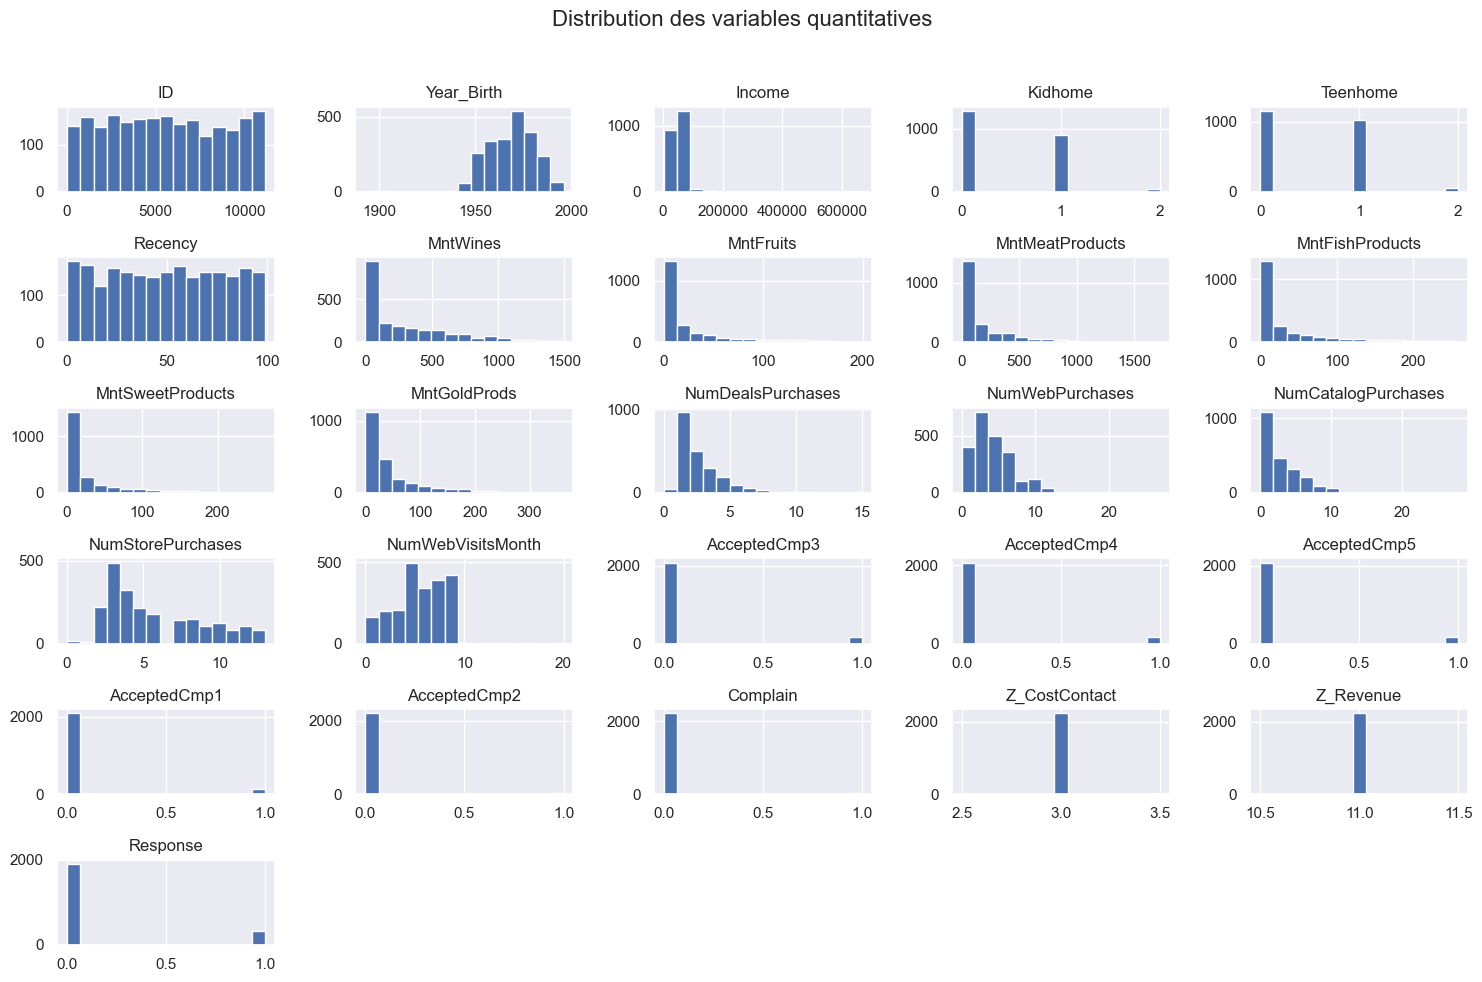

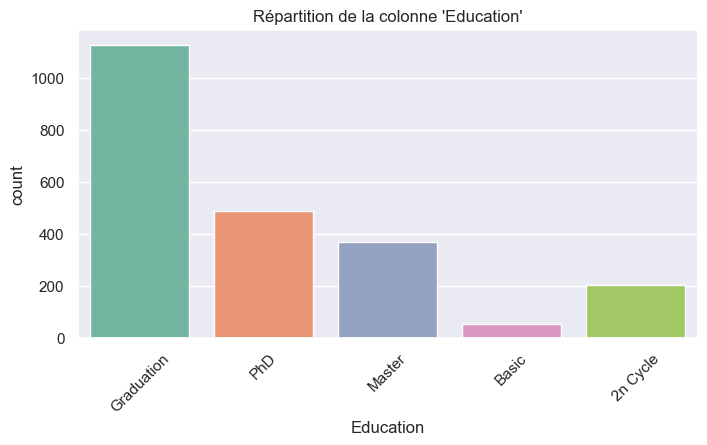

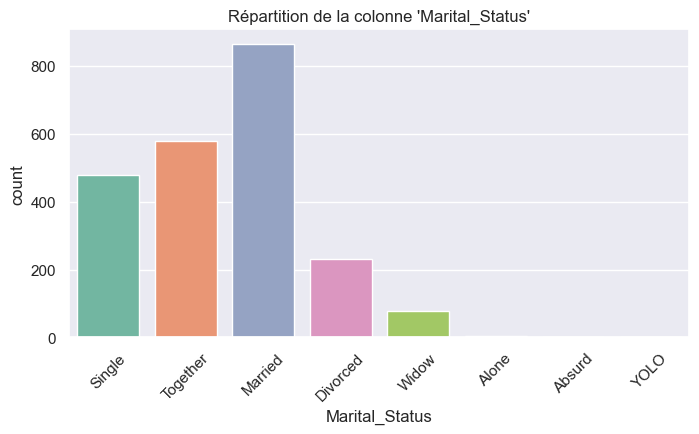

In [43]:
# Sélectionner uniquement les colonnes numériques
numerical_cols = df_customers.select_dtypes(include=['int64', 'float64']).columns

# Tracer la distribution des colonnes numériques
df_customers[numerical_cols].hist(figsize=(15, 10), bins=15)
plt.suptitle("Distribution des variables quantitatives", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Visualiser la répartition des variables catégorielles ###
categorical_cols = df_customers.select_dtypes(include=['object']).columns

# Afficher la répartition de la variable catégorielle 'Education'
plt.figure(figsize=(8, 4))
sns.countplot(data=df_customers, x='Education', palette='Set2')
plt.title("Répartition de la colonne 'Education'")
plt.xticks(rotation=45)
plt.show()

# Afficher la répartition de la variable catégorielle 'Marital_Status'
plt.figure(figsize=(8, 4))
sns.countplot(data=df_customers, x='Marital_Status', palette='Set2')
plt.title("Répartition de la colonne 'Marital_Status'")
plt.xticks(rotation=45)
plt.show()

Nous allons maintenant faire du *feature engineering* pour simplifier le jeu de données. Cela permettra d'orienter le clustering vers la réponse que l'on veut à la tâche.

Par exemple, si l'on veut regrouper les clients par habitudes de consommation, il peut être intéressant de conserver les données sur le nombre d'achats de viande, de poisson, de vins, etc. En revanche, si l'on veut regrouper les clients par dépenses totales, on peut remplacer ces colonnes par leur somme.

Ce *feature engineering* dépend surtout des décideurs et de ce dont ils ont besoin. Dans la pratique, on essaie souvent plusieurs façons de retravailler les *features* avant de trouver une façon qui donne une réponse intéressante...

In [44]:
# On va travailler sur une copie du DataFrame pour garder les données originales intactes, au cas où.
df_customers2 = df_customers.copy()

Q3. Construisez une nouvelle colonne `"Age"` à partir de `"Year_Birth"` dans `df_customers2`.

Note : le jeu de données a été collecté en 2014.

   Year_Birth  Age
0        1957   57
1        1954   60
2        1965   49
3        1984   30
4        1981   33


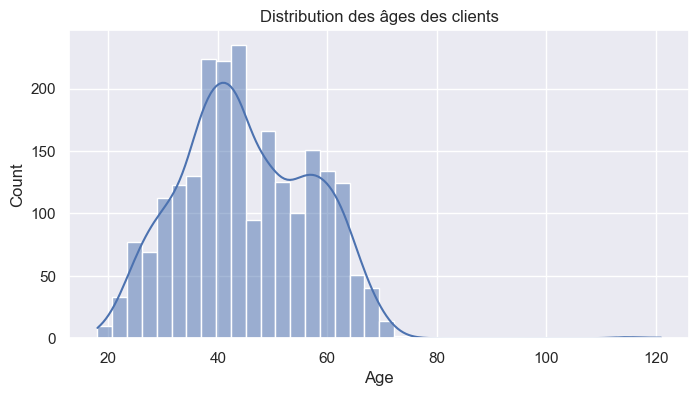

In [45]:
# Création de la colonne "Age" à partir de l'année de naissance (Year_Birth)
df_customers2['Age'] = 2014 - df_customers2['Year_Birth']

# Vérifier la nouvelle colonne "Age"
print(df_customers2[['Year_Birth', 'Age']].head())

# Visualiser la distribution des âges
plt.figure(figsize=(8, 4))
sns.histplot(df_customers2['Age'], kde=True)
plt.title("Distribution des âges des clients")
plt.show()

Q4. Encodez la colonne `'Education'`. Quel encodage vous semble approprié ?

    Education  Education_Encoded
0  Graduation                2.0
1  Graduation                2.0
2  Graduation                2.0
3  Graduation                2.0
4         PhD                4.0


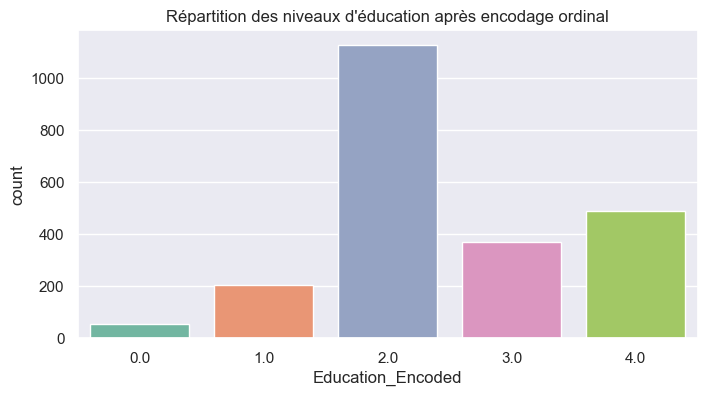

In [46]:
# Définir l'ordre des catégories pour l'encodage ordinal
education_order = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']

# Appliquer l'encodage ordinal
ordinal_encoder = OrdinalEncoder(categories=[education_order])

# Appliquer l'encodage à la colonne Education
df_customers2['Education_Encoded'] = ordinal_encoder.fit_transform(df_customers2[['Education']])

# Vérifier le résultat
print(df_customers2[['Education', 'Education_Encoded']].head())

# Visualiser la répartition après encodage
plt.figure(figsize=(8, 4))
sns.countplot(x='Education_Encoded', data=df_customers2, palette='Set2')
plt.title("Répartition des niveaux d'éducation après encodage ordinal")
plt.show() 

Q5. Encodez la colonne `Marital_Status`. Pour simplifier les données et limiter le nombre de catégories, on ne voudra retenir que 2 catégories :

- les gens en couple, qu'ils soient marriés ou non ;
- les gens vivant seuls, qu'ils soient célibataires, divorcés, veufs.

Il existe des données rares et qui risquent de faire chuter la performance, vous pouvez les supprimer ou les regrouper dans la catégorie qui vous semble la plus pertinente.

En couple       1444
Vivant seuls     796
Name: Marital_Status_Simplified, dtype: int64
  Marital_Status Marital_Status_Simplified  Marital_Status_Encoded
0         Single              Vivant seuls                       0
1         Single              Vivant seuls                       0
2       Together                 En couple                       1
3       Together                 En couple                       1
4        Married                 En couple                       1


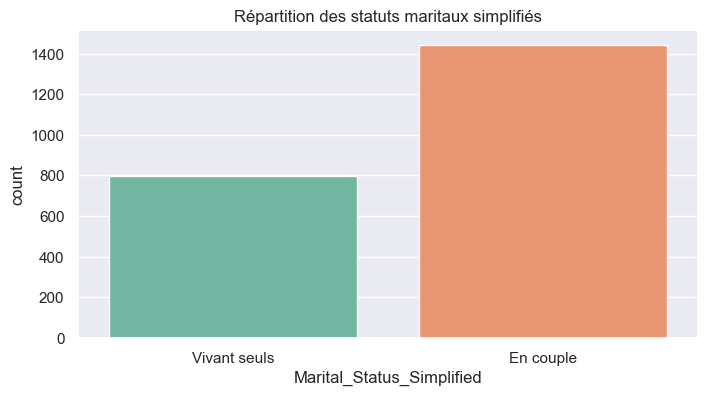

In [47]:
# Regrouper les statuts maritaux en deux catégories : 'En couple' et 'Vivant seuls'
df_customers2['Marital_Status_Simplified'] = df_customers2['Marital_Status'].replace({
    'Married': 'En couple',
    'Together': 'En couple',
    'Single': 'Vivant seuls',
    'Divorced': 'Vivant seuls',
    'Widow': 'Vivant seuls',
    'Alone': 'Vivant seuls',  # Statut rare mais regroupé dans 'Vivant seuls'
    'Absurd': 'Vivant seuls',  # Statut rare mais regroupé dans 'Vivant seuls'
    'YOLO': 'Vivant seuls'    # Statut rare mais regroupé dans 'Vivant seuls'
})

# Vérifier la nouvelle colonne
print(df_customers2['Marital_Status_Simplified'].value_counts())

# Encodage binaire : 0 = Vivant seuls, 1 = En couple
df_customers2['Marital_Status_Encoded'] = df_customers2['Marital_Status_Simplified'].map({
    'Vivant seuls': 0,
    'En couple': 1
})

# Vérifier le résultat
print(df_customers2[['Marital_Status', 'Marital_Status_Simplified', 'Marital_Status_Encoded']].head())

# Visualiser la répartition après encodage
plt.figure(figsize=(8, 4))
sns.countplot(x='Marital_Status_Simplified', data=df_customers2, palette='Set2')
plt.title("Répartition des statuts maritaux simplifiés")
plt.show()

Q6. Construisez une nouvelle colonne `"Children"` qui correspond à la somme des enfants (`Kidhome`) et adolescents (`Teenhome`).

   Kidhome  Teenhome  Children
0        0         0         0
1        1         1         2
2        0         0         0
3        1         0         1
4        1         0         1


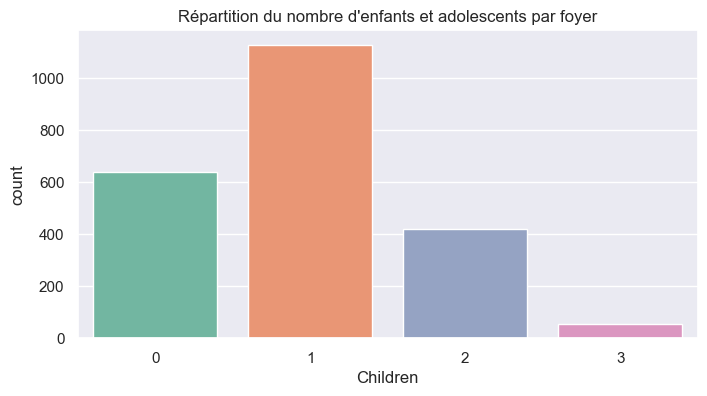

In [48]:
# Créer la colonne "Children" qui correspond à la somme des enfants et adolescents
df_customers2['Children'] = df_customers2['Kidhome'] + df_customers2['Teenhome']

# Vérifier la nouvelle colonne "Children"
print(df_customers2[['Kidhome', 'Teenhome', 'Children']].head())

# Visualiser la distribution de la colonne "Children"
plt.figure(figsize=(8, 4))
sns.countplot(x='Children', data=df_customers2, palette='Set2')
plt.title("Répartition du nombre d'enfants et adolescents par foyer")
plt.show()

Q7. Construisez une nouvelle colonne `"Seniority"` qui correspond au nombre de mois écoulés depuis l'inscription du client (`"Dt_Customer"`).

On vous précise ci-dessous une variable `last_date` qui correspond à la date par rapport à laquelle faire la différence (temps écoulé), c'est-à-dire fin 2014.

Vous devriez d'abord convertir la colonne en `datetime` via [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) : lisez bien la documentation concernant le format des données.
Les objets de type `datetime` permettent des manipulations temporelles simplifiées (par rapport à si on manipulait "juste" des ints) : on peut demander le nombre de jours, le nombre de secondes, etc.

<details>
<summary>Astuce</summary>

Vous pouvez utiliser `s.dt.date` (avec `s` un objet de type `Series`, c'est-à-dire une colonne du DataFrame) pour faire des traitements sur les dates.

La méthode [`s.dt.date.apply()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html) sera utile pour appliquer une transformation (fonction) à chacun des éléments de la colonne.

Puis vous pourrez utiliser `s.dt.days` pour récupérer le résultat sous forme de jours. Il ne restera plus qu'à le transformer en mois !
</details>

In [49]:
from datetime import date

last_date = date(2014, 12, 31)

  Dt_Customer
0  2012-09-04
1  2014-03-08
2  2013-08-21
3  2014-02-10
4  2014-01-19
  Dt_Customer  Days_Since_Enrollment  Seniority
0  2012-09-04                    848         28
1  2014-03-08                    298          9
2  2013-08-21                    497         16
3  2014-02-10                    324         10
4  2014-01-19                    346         11


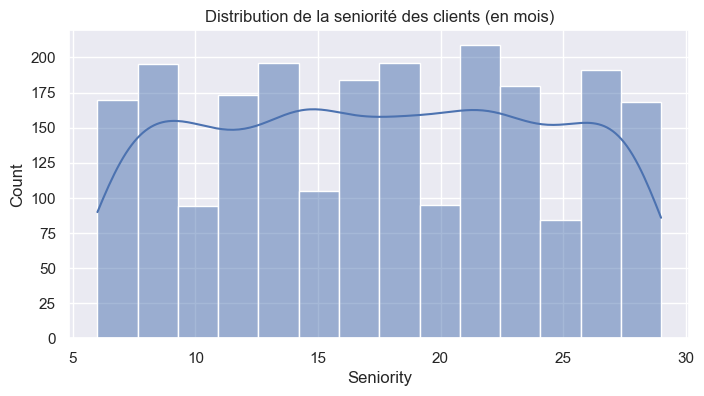

In [50]:
# Convertir la colonne 'Dt_Customer' en format datetime sans spécifier de format, Pandas va inférer automatiquement
df_customers2['Dt_Customer'] = pd.to_datetime(df_customers2['Dt_Customer'], dayfirst=True, errors='coerce')

# Vérifier la conversion et s'assurer qu'il n'y a pas de valeurs incorrectes
print(df_customers2[['Dt_Customer']].head())

# Calculer la différence entre 'last_date' et 'Dt_Customer' en jours
df_customers2['Days_Since_Enrollment'] = (pd.to_datetime(last_date) - df_customers2['Dt_Customer']).dt.days

# Convertir les jours en mois (approximativement)
df_customers2['Seniority'] = (df_customers2['Days_Since_Enrollment'] / 30).astype(int)

# Vérifier les premières lignes pour valider le calcul
print(df_customers2[['Dt_Customer', 'Days_Since_Enrollment', 'Seniority']].head())

# Visualiser la distribution de la seniorité des clients
plt.figure(figsize=(8, 4))
sns.histplot(df_customers2['Seniority'], kde=True)
plt.title("Distribution de la seniorité des clients (en mois)")
plt.show()

Q8. Construisez la colonne `"AcceptedOffers"`, qui correspond à la somme des offres acceptées (`"AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"`).

   AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   AcceptedOffers  
0               0  
1               0  
2               0  
3               0  
4               0  


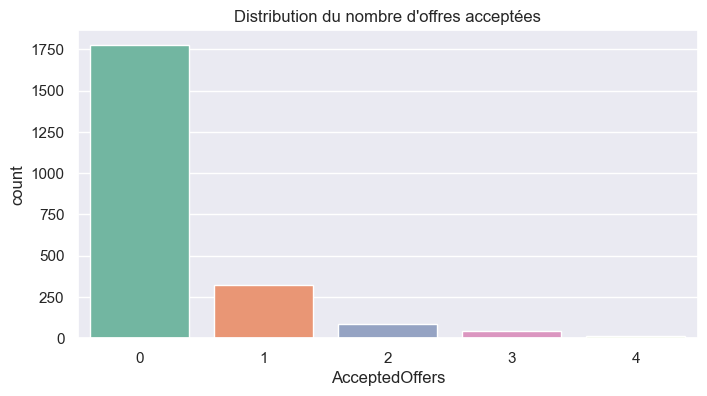

In [51]:
# Créer la colonne 'AcceptedOffers' en additionnant les colonnes des campagnes acceptées
df_customers2['AcceptedOffers'] = df_customers2[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Vérifier les premières lignes de la nouvelle colonne
print(df_customers2[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedOffers']].head())

# Visualiser la distribution des offres acceptées
plt.figure(figsize=(8, 4))
sns.countplot(x='AcceptedOffers', data=df_customers2, palette='Set2')
plt.title("Distribution du nombre d'offres acceptées")
plt.show()

Q9. Construisez une nouvelle colonne `"Expenses"`, qui correspond à la somme des dépenses pour tous les types de produits (`"MntWines", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"`).

Note : ici, on pourrait vouloir avoir une granularité plus fine et conserver ces colonnes, si on voulait catégoriser les clients selon qu'ils achètent plutôt de la viande, plutôt du vin, ... Cette simplification que je propose est **une** façon de faire, ce n'est pas la seule ni forcément la meilleure ! (Elle a l'avantage de diminuer le nombre de *features* pour l'interprétation donc de raccourcir le temps nécessaire pour ce TP...)

   MntWines  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
0       635              546              172                88            88   
1        11                6                2                 1             6   
2       426              127              111                21            42   
3        11               20               10                 3             5   
4       173              118               46                27            15   

   Expenses  
0      1617  
1        27  
2       776  
3        53  
4       422  


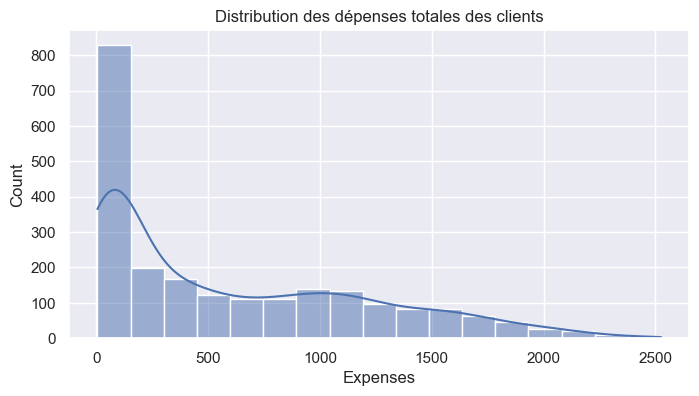

In [52]:
# Créer la colonne 'Expenses' en additionnant les colonnes des différentes dépenses
df_customers2['Expenses'] = df_customers2[['MntWines', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','MntFruits']].sum(axis=1)

# Vérifier les premières lignes de la nouvelle colonne 'Expenses'
print(df_customers2[['MntWines', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Expenses']].head())

# Visualiser la distribution des dépenses totales
plt.figure(figsize=(8, 4))
sns.histplot(df_customers2['Expenses'], kde=True)
plt.title("Distribution des dépenses totales des clients")
plt.show()

Q10. Construisez une nouvelle colonne `"AllNumberPurchases"`, qui correspond à la somme du nombre d'achats, quelle que soit l'origine de ces achats (Web : `"NumWebPurchases"`, catalogue : `"NumCatalogPurchases"`, en magasin : `"NumStorePurchases"`, par offre promotionnelle : `"NumDealsPurchases"`).

Note : là encore, il s'agit d'**une** façon de faire...

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumDealsPurchases  \
0                8                   10                  4                  3   
1                1                    1                  2                  2   
2                8                    2                 10                  1   
3                2                    0                  4                  2   
4                5                    3                  6                  5   

   AllNumberPurchases  
0                  25  
1                   6  
2                  21  
3                   8  
4                  19  


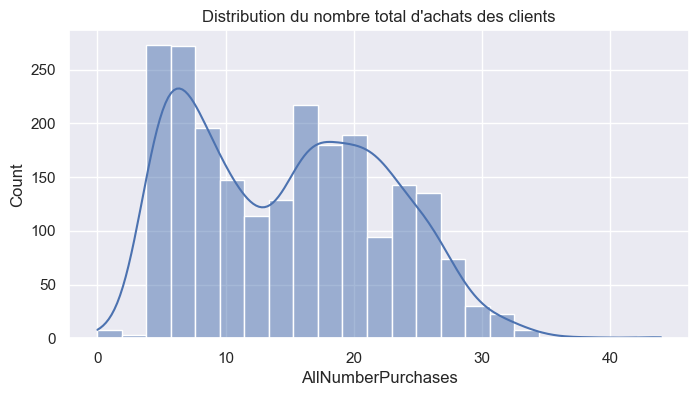

In [53]:
# Créer la colonne 'AllNumberPurchases' en additionnant les colonnes des différents types d'achats
df_customers2['AllNumberPurchases'] = df_customers2[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases']].sum(axis=1)

# Vérifier les premières lignes de la nouvelle colonne 'AllNumberPurchases'
print(df_customers2[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'AllNumberPurchases']].head())

# Visualiser la distribution du nombre total d'achats
plt.figure(figsize=(8, 4))
sns.histplot(df_customers2['AllNumberPurchases'], kde=True)
plt.title("Distribution du nombre total d'achats des clients")
plt.show()

Q11. Supprimez les colonnes inutiles ou que nous avons utilisé pour construire d'autres colonnes.

Au final, nous voulons garder : `Age, Education, Marital_Status, Income, Children, Seniority, Recency, Complain, Expenses, AcceptedOffers, NumWebVisitsMonth, All_NumPurchases`

C'est-à-dire que nous devons supprimer : `ID, Year_Birth, Kidhome, Teenhome, Dt_Customer, AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCm4, AcceptedCmp4, AcceptedCmp5, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, Z_CostContact, Z_Revenue, Response`

In [54]:
# Liste des colonnes à supprimer
columns_to_drop = ['ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 
                   'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                   'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
                   'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 
                   'Z_CostContact', 'Z_Revenue', 'Response']

# Supprimer les colonnes inutiles
df_customers2 = df_customers2.drop(columns=columns_to_drop)

# Vérifier la structure du DataFrame final
print(df_customers2.info())

# Afficher les premières lignes pour vérifier
print(df_customers2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  2240 non-null   object 
 1   Marital_Status             2240 non-null   object 
 2   Income                     2216 non-null   float64
 3   Recency                    2240 non-null   int64  
 4   NumWebVisitsMonth          2240 non-null   int64  
 5   Complain                   2240 non-null   int64  
 6   Age                        2240 non-null   int64  
 7   Education_Encoded          2240 non-null   float64
 8   Marital_Status_Simplified  2240 non-null   object 
 9   Marital_Status_Encoded     2240 non-null   int64  
 10  Children                   2240 non-null   int64  
 11  Days_Since_Enrollment      2240 non-null   int64  
 12  Seniority                  2240 non-null   int64  
 13  AcceptedOffers             2240 non-null   int64

Q12. Il y a peu de données manquantes, et elles sont toutes dans la colonne `"Income"` : c'est une situation idéale pour essayer de les remplacer, plutôt que de les supprimer ! Imputez les valeurs manquantes de la colonne `"Income"` dans un DataFrame `df_customers3` en utilisant la médiane comme valeur de remplacement.

Étant donnée la distribution des données, c'est une solution un peu robuste (beaucoup plus que d'utiliser la moyenne !), mais qui peut vite montrer ses limites s'il existe des corrélations entre cette colonne et d'autres (qui ne seront pas capturées par une simple médiane).

Pour aller plus loin => vous trouverez un exercice bonus en fin de sujet sur l'utilisation de l'algorithme **MissForest**, se basant (comme son nom l'indique) sur les forêts aléatoires.

<details>
<summary>Astuce</summary>

Vous pourrez utiliser la méthode [`df.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) pour remplir automatiquement les NA. Regardez bien les paramètres pour savoir comment configurer la valeur de remplacement.
</details>

0


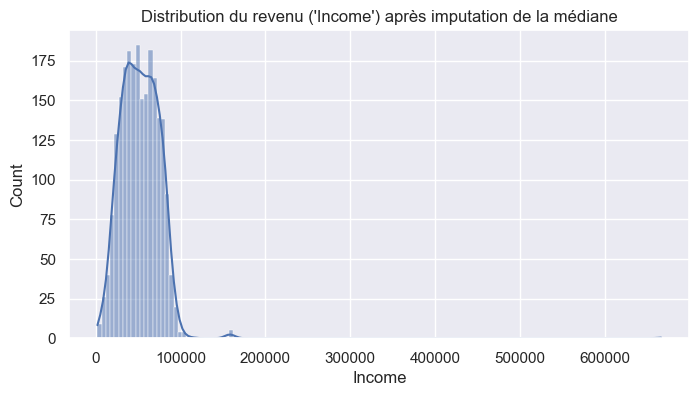

In [55]:
# Copier le DataFrame pour préserver les données originales
df_customers3 = df_customers2.copy()

# Calculer la médiane de la colonne 'Income'
income_median = df_customers3['Income'].median()

# Remplacer les valeurs manquantes de 'Income' par la médiane
df_customers3['Income'] = df_customers3['Income'].fillna(income_median)

# Vérifier si les valeurs manquantes ont été imputées
print(df_customers3['Income'].isnull().sum())  # Doit renvoyer 0

# Vérifier la distribution de la colonne 'Income' après imputation
plt.figure(figsize=(8, 4))
sns.histplot(df_customers3['Income'], kde=True)
plt.title("Distribution du revenu ('Income') après imputation de la médiane")
plt.show()


Q13. Nous allons maintenant normaliser les données dans un DataFrame `df_customers4`, afin d'entraîner ensuite un algorithme de clustering. KMeans, par exemple, est particulièrement sensible aux différentes échelles dans les données. Reprenez l'EDA, on se focalisant sur les données numériques qui ont une grande échelle (analyse univariée à nouveau), puis choisissez une méthode de normalisation pour chacune des colonnes.

On rappelle les méthodes de normalisation : min-max (linéaire), z-norm, log. Chacune de ces méthodes peut être avec ou sans *clipping*.

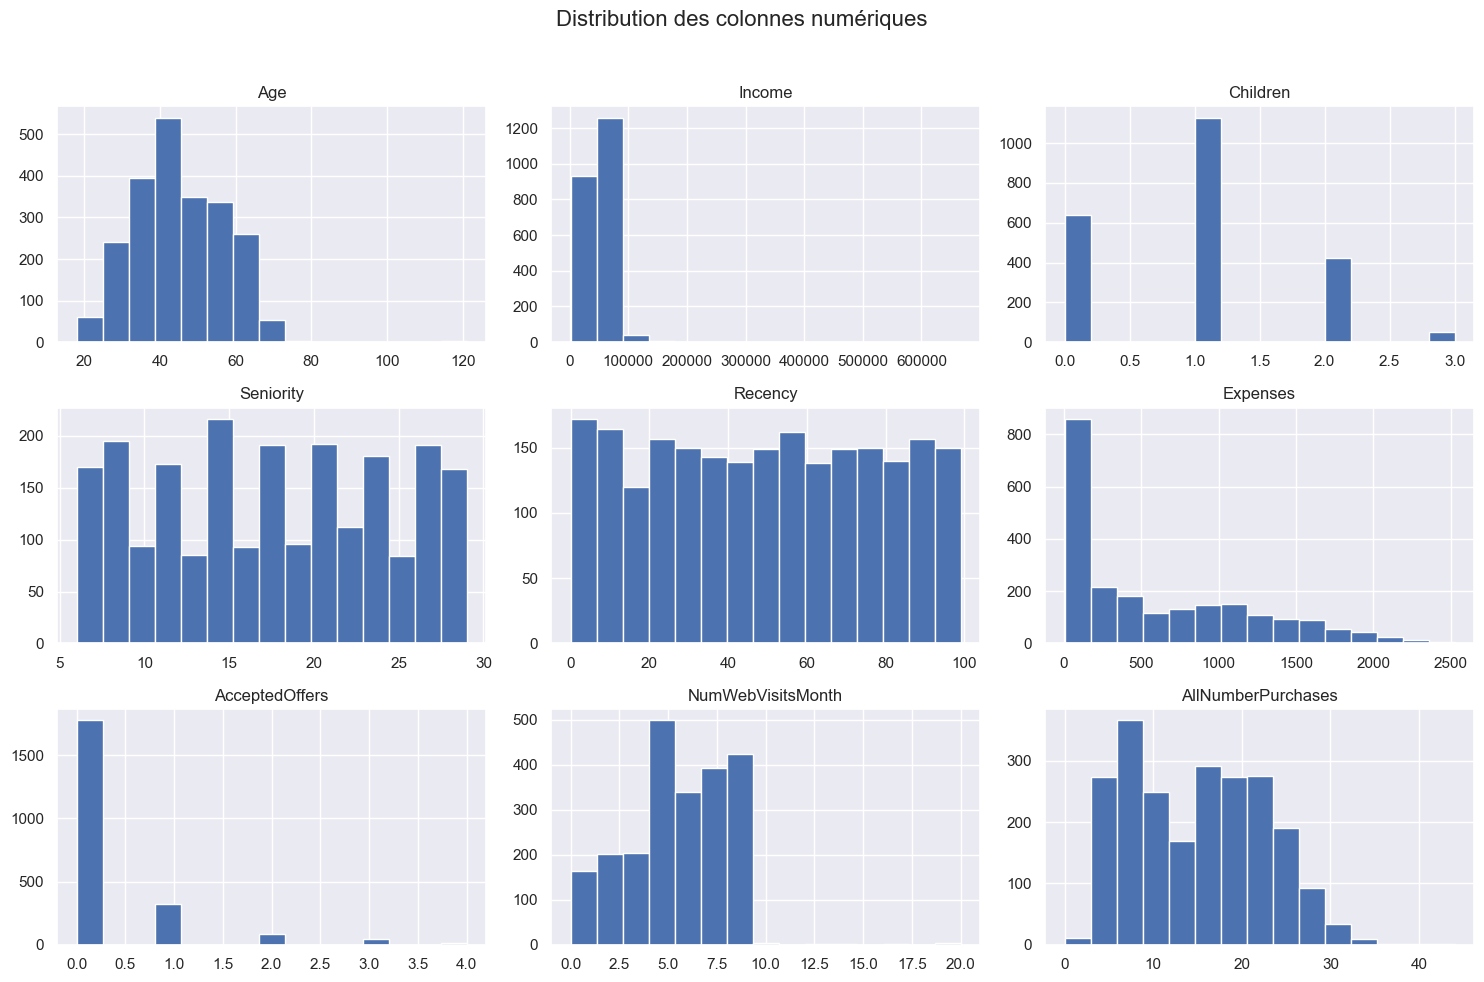

In [56]:

# Sélectionner les colonnes numériques pour l'analyse
numerical_columns = ['Age', 'Income', 'Children', 'Seniority', 'Recency', 'Expenses', 'AcceptedOffers', 'NumWebVisitsMonth', 'AllNumberPurchases']

# Afficher la distribution des colonnes numériques
df_customers3[numerical_columns].hist(figsize=(15, 10), bins=15)
plt.suptitle("Distribution des colonnes numériques", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [57]:
# Copier le DataFrame pour créer df_customers4
df_customers4 = df_customers3.copy()

# Z-Normalisation pour Age, Seniority, Recency
scaler_z = StandardScaler()
df_customers4[['Age', 'Seniority', 'Recency']] = scaler_z.fit_transform(df_customers4[['Age', 'Seniority', 'Recency']])

# Logarithmique avec clipping pour Income et Expenses
df_customers4['Income_log'] = np.log1p(df_customers4['Income'].clip(lower=1))  # log(1 + Income)
df_customers4['Expenses_log'] = np.log1p(df_customers4['Expenses'].clip(lower=1))  # log(1 + Expenses)

# Min-Max Normalisation pour Children, AcceptedOffers, NumWebVisitsMonth, AllNumberPurchases
scaler_minmax = MinMaxScaler()
df_customers4[['Children', 'AcceptedOffers', 'NumWebVisitsMonth', 'AllNumberPurchases', 'Education_Encoded', 'Marital_Status_Encoded']] = scaler_minmax.fit_transform(
    df_customers4[['Children', 'AcceptedOffers', 'NumWebVisitsMonth', 'AllNumberPurchases', 'Education_Encoded', 'Marital_Status_Encoded']]
)

# Supprimer les colonnes non normalisées (Income, Expenses) et garder les versions log
df_customers4 = df_customers4.drop(columns=['Income', 'Expenses', 'Education', 'Marital_Status', 'Marital_Status_Simplified'])

# Vérifier le DataFrame final
print(df_customers4.head())

    Recency  NumWebVisitsMonth  Complain       Age  Education_Encoded  \
0  0.307039               0.35         0  0.985345                0.5   
1 -0.383664               0.25         0  1.235733                0.5   
2 -0.798086               0.20         0  0.317643                0.5   
3 -0.798086               0.30         0 -1.268149                0.5   
4  1.550305               0.25         0 -1.017761                1.0   

   Marital_Status_Encoded  Children  Days_Since_Enrollment  Seniority  \
0                     0.0  0.000000                    848   1.560500   
1                     0.0  0.666667                    298  -1.256076   
2                     1.0  0.000000                    497  -0.218391   
3                     1.0  0.333333                    324  -1.107836   
4                     1.0  0.333333                    346  -0.959595   

   AcceptedOffers  AllNumberPurchases  Income_log  Expenses_log  
0             0.0            0.568182   10.970592      7

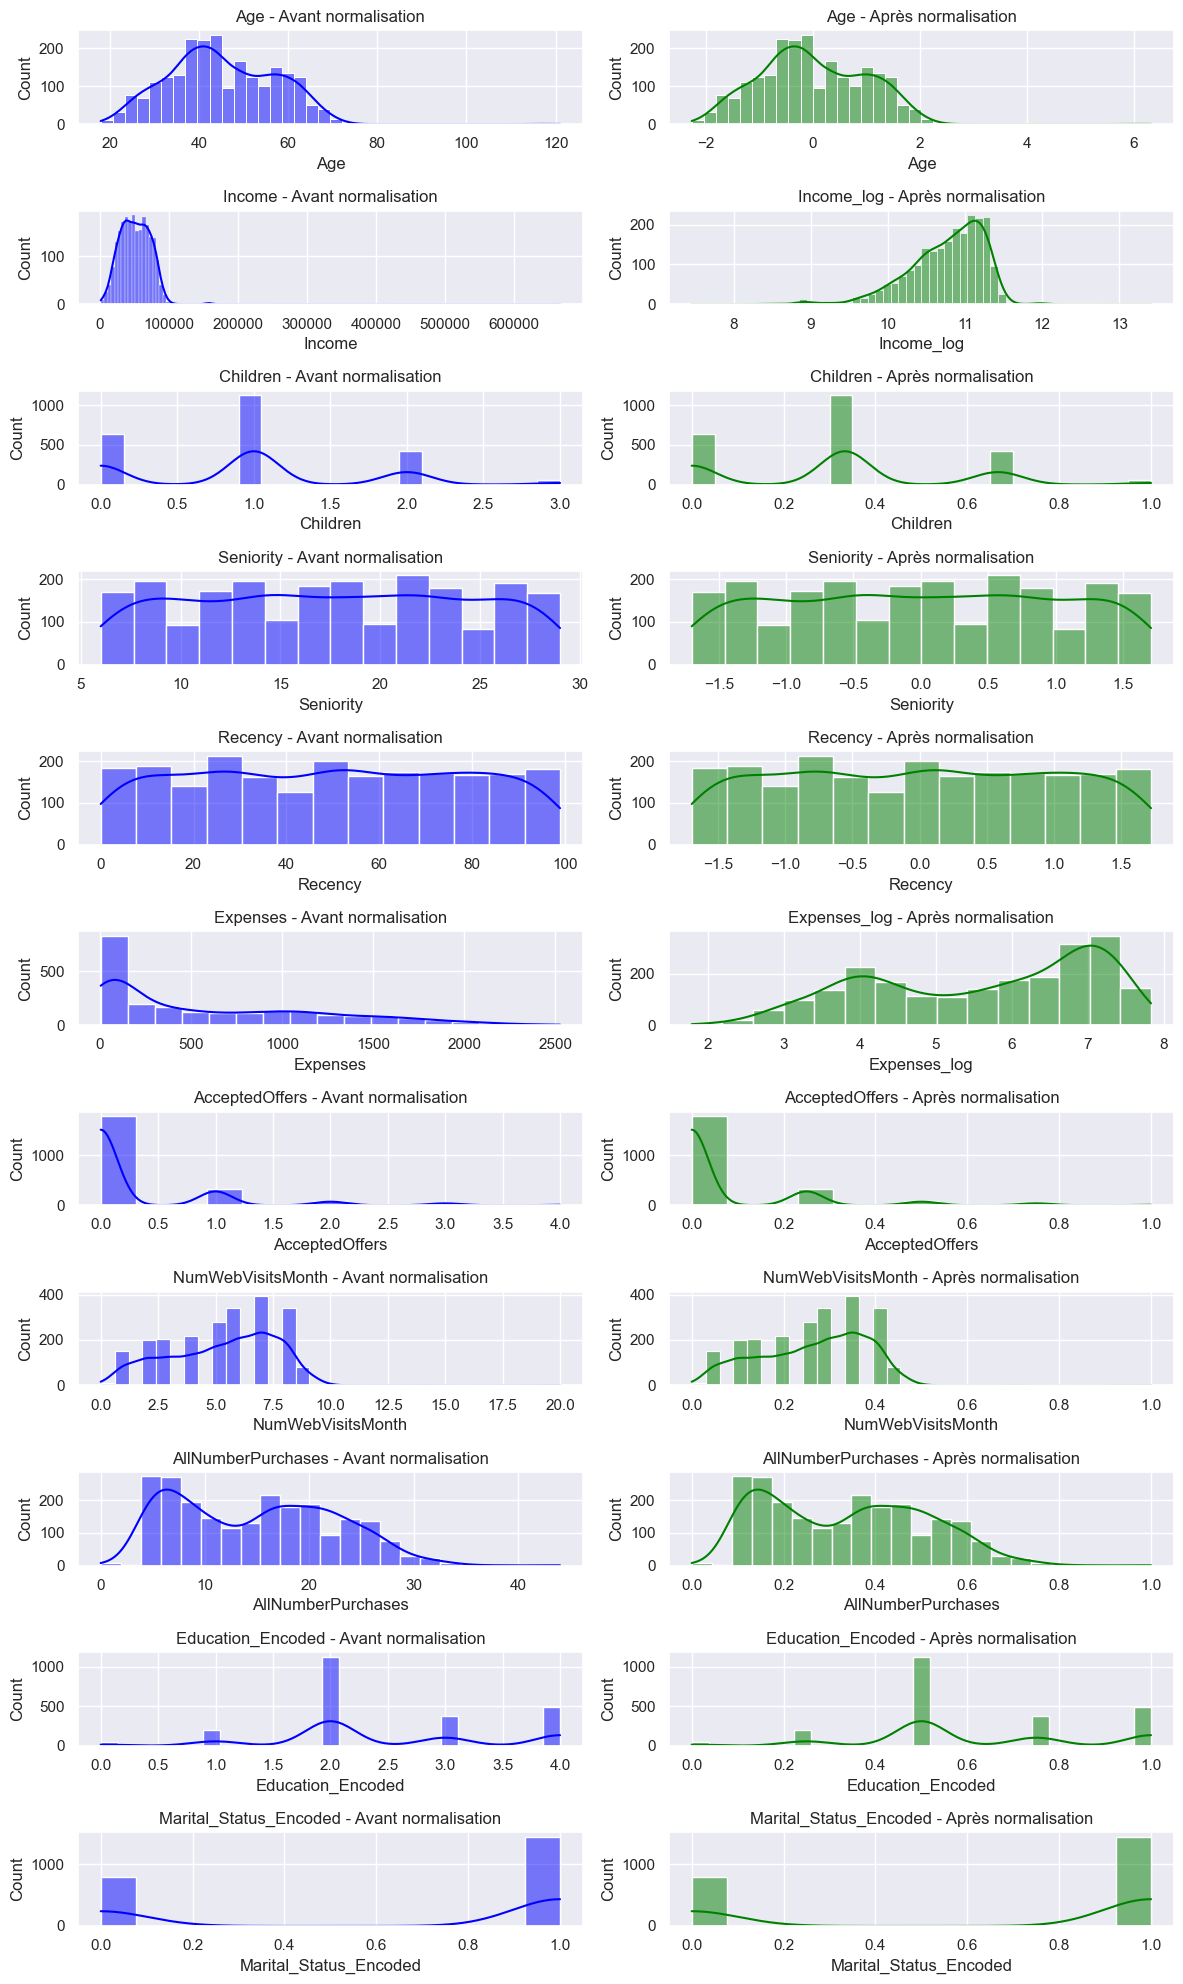

In [58]:
# Sélectionner les colonnes originales et les colonnes normalisées pour la comparaison
original_columns = ['Age', 'Income', 'Children', 'Seniority', 'Recency', 'Expenses', 'AcceptedOffers', 'NumWebVisitsMonth', 'AllNumberPurchases', 'Education_Encoded', 'Marital_Status_Encoded']
normalized_columns = ['Age', 'Income_log', 'Children', 'Seniority', 'Recency', 'Expenses_log', 'AcceptedOffers', 'NumWebVisitsMonth', 'AllNumberPurchases', 'Education_Encoded', 'Marital_Status_Encoded']

# Création de subplots pour comparer avant et après la normalisation
fig, axes = plt.subplots(len(original_columns), 2, figsize=(12, 20))

# Parcourir chaque colonne et afficher l'avant et l'après normalisation
for i, col in enumerate(original_columns):
    # Avant normalisation
    sns.histplot(df_customers3[col], kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'{col} - Avant normalisation')
    
    # Après normalisation
    normalized_col = normalized_columns[i]
    sns.histplot(df_customers4[normalized_col], kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{normalized_col} - Après normalisation')

plt.tight_layout()
plt.show()

Q14. Nous allons maintenant effectuer un algorithme de clustering (KMeans) sur les données.

Nous n'avons aucune idée sur le nombre de clusters à apprendre ; nous allons donc devoir le déterminer empiriquement. On utilisera pour cela la méthode du coefficient de silhouette.

Créez un dictionnaire `results` dans lequel vos clés seront le nombre de clusters `k` et vos valeurs seront les modèles appris.
Puis, pour plusieurs `k` (à vous de choisir lesquels !), entraînez un modèle de KMeans et mémorisez les résultats (les modèles entraînés) dans le dictionnaire.

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Créer un dictionnaire pour stocker les résultats
results = {}

# Définir la plage de valeurs de k à tester (par exemple de 2 à 10 clusters)
k_values = range(2, 21)

# Entraîner un modèle KMeans pour chaque k et stocker les résultats dans le dictionnaire
for k in k_values:
    # Initialiser et entraîner le modèle KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers4)  # Utiliser seulement les colonnes numériques
    
    # Stocker le modèle dans le dictionnaire
    results[k] = kmeans
    
    # Prédire les clusters pour le calcul du coefficient de silhouette
    labels = kmeans.labels_
    
    # Calculer le coefficient de silhouette
    silhouette_avg = silhouette_score(df_customers4, labels)
    
    # Afficher le score silhouette pour chaque k
    # print(f"Pour k={k}, le coefficient de silhouette est de {silhouette_avg:.3f}")

# Afficher les modèles entraînés
print(f"\nModèles KMeans entraînés pour k={list(k_values)}")



Modèles KMeans entraînés pour k=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Q15. Calculez les coefficients de silhouette pour chacun des `k`, à partir des modèles KMeans (entraînés) correspondants. Affichez ensuite la courbe des coefficients de silhouette par rapport aux `k`.

Vous pourrez utiliser pour cela la fonction [`sklearn.metrics.silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

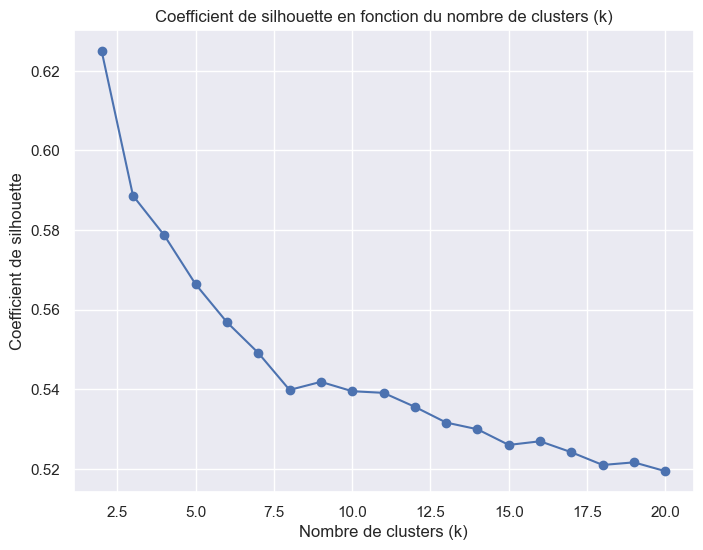

In [60]:
# Définir les valeurs de k
k_values = list(results.keys())

# Stocker les coefficients de silhouette pour chaque k
silhouette_scores = []

# Calculer les coefficients de silhouette pour chaque modèle stocké dans le dictionnaire 'results'
for k in k_values:
    kmeans = results[k]
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_customers4, labels)
    silhouette_scores.append(silhouette_avg)

# Tracer la courbe des coefficients de silhouette en fonction de k
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Coefficient de silhouette en fonction du nombre de clusters (k)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Coefficient de silhouette")
plt.grid(True)
plt.show()

Q16. Quel est le nombre `k` optimal selon votre courbe ? Nous allons utiliser à partir de maintenant le modèle KMeans correspondant à cet hyperparamètre optimal.

Comment interpréter cette valeur par rapport au contexte du problème ? Rappel : on veut grouper les clients par rapport à leurs caractéristiques d'achats.

Interprétation de k=2 :
Dans le contexte de ce problème, où l'objectif est de regrouper les clients selon leurs caractéristiques d'achats, un nombre de clusters optimal de 2 peut suggérer que :

Il existe deux grandes catégories de clients dans tes données.
Ces deux groupes pourraient représenter des segments très différents en termes de comportement d'achat, par exemple :
Un groupe de clients "économiques" : Ces clients dépensent moins, achètent moins souvent ou se concentrent sur des produits spécifiques.
Un groupe de clients "haut de gamme" : Ces clients dépensent plus, achètent plus souvent, ou préfèrent une variété de produits.

   Cluster
0        1
1        0
2        0
3        0
4        0
1    1126
0    1114
Name: Cluster, dtype: int64


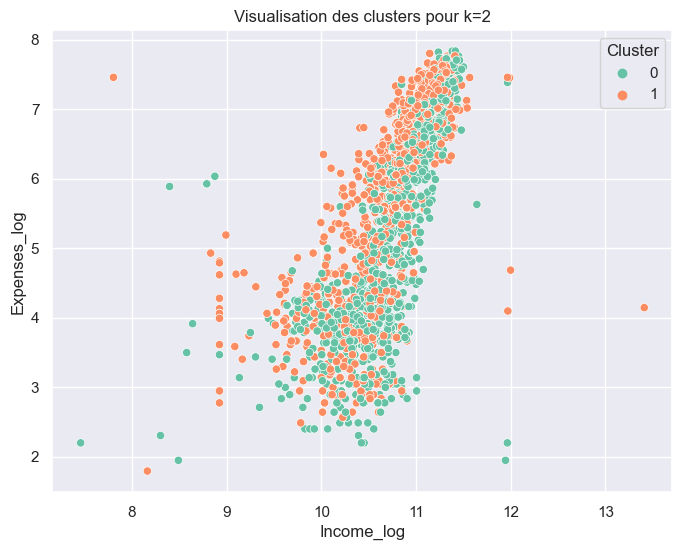

In [61]:
# Récupérer le modèle KMeans pour k=2
optimal_k = 2
kmeans_optimal = results[optimal_k]

# Ajouter les clusters au DataFrame des clients
df_customers4['Cluster'] = kmeans_optimal.labels_

# Afficher les 5 premières lignes du DataFrame avec les clusters
print(df_customers4[['Cluster']].head())

# Analyser la répartition des clients dans les clusters
print(df_customers4['Cluster'].value_counts())

# Visualiser les clusters en fonction de deux caractéristiques d'achat
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income_log', y='Expenses_log', hue='Cluster', data=df_customers4, palette='Set2')
plt.title(f'Visualisation des clusters pour k={optimal_k}')
plt.show()

Q17. On veut visualiser quelles *features* sont les plus importantes pour le clustering.

Pour cela, commencez par apprendre un classifieur *RandomForest*, en considérant que les clusters sont des *labels*.
(Cela permet d'apprendre une relation entre les *features* et le cluster prédit)

                   Feature  Importance
7    Days_Since_Enrollment    0.547760
8                Seniority    0.407117
1        NumWebVisitsMonth    0.017899
12            Expenses_log    0.008882
10      AllNumberPurchases    0.008111
11              Income_log    0.003826
3                      Age    0.002167
0                  Recency    0.001736
4        Education_Encoded    0.001021
9           AcceptedOffers    0.000627
6                 Children    0.000607
5   Marital_Status_Encoded    0.000173
2                 Complain    0.000076


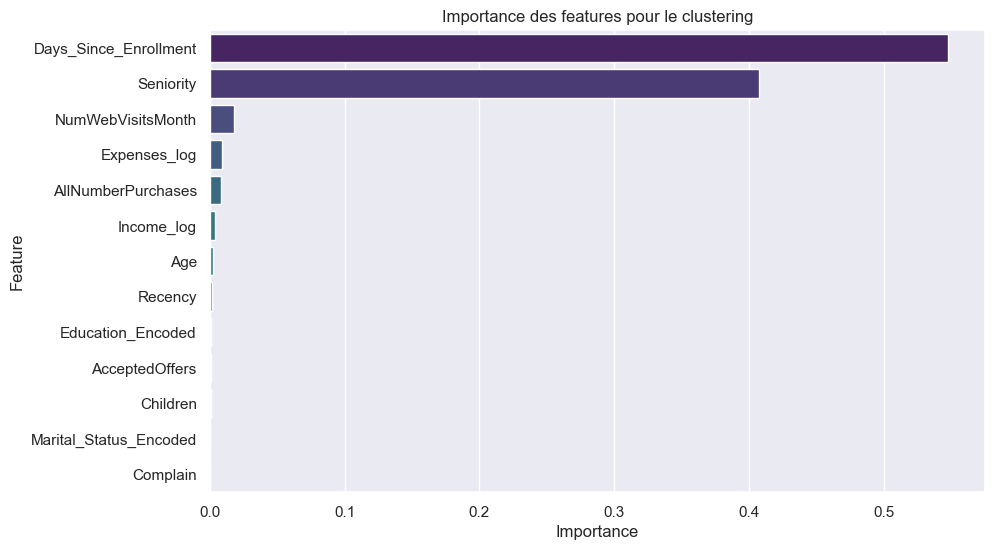

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Sélectionner les colonnes de features (les colonnes numériques normalisées)
features = df_customers4.drop(columns='Cluster')

# Les clusters comme labels
labels = df_customers4['Cluster']

# Initialiser le modèle RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Entraîner le modèle sur les features et les clusters (labels)
rf_clf.fit(features, labels)

# Extraire l'importance des features
feature_importances = rf_clf.feature_importances_

# Créer un DataFrame pour afficher les importances
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Afficher les importances des features
print(feature_importance_df)

# Visualiser les importances avec un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Importance des features pour le clustering")
plt.show()


Q18. Maintenant que nous disposons d'un classifieur entraîné, on veut calculer l'importance de chaque *feature*. Utilisez [`sklearn.inspection.permutation_importance()`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) pour calculer ces importances à partir de la *Random Forest* (entraînée !), sur l'ensemble des données, puis visualisez-les graphiquement.

<details>
<summary>Astuce</summary>

Le calcul de l'importance par permutation effectue plusieurs permutations (pour chaque *feature*) ; on obtient donc une distribution (un tableau 2D) d'importances (des valeurs pour chaque *feature* et chaque répétition).
On veut visualiser à la fois la moyenne et l'écart-type des importances pour chaque *feature*, pour avoir une visualisation un peu plus fine que simplement la moyenne.
Utilisez maplotlib ou seaborn de manière à affichez un diagramme en bâtons (par exemple), avec affichage de l'écart-type (sous forme d'un paramètre souvent appelé "erreur d'estimation").
</details>

                   Feature  Importance_Mean  Importance_STD
7    Days_Since_Enrollment         0.500789        0.010567
8                Seniority         0.000208        0.000223
0                  Recency         0.000000        0.000000
1        NumWebVisitsMonth         0.000000        0.000000
2                 Complain         0.000000        0.000000
3                      Age         0.000000        0.000000
4        Education_Encoded         0.000000        0.000000
5   Marital_Status_Encoded         0.000000        0.000000
6                 Children         0.000000        0.000000
9           AcceptedOffers         0.000000        0.000000
10      AllNumberPurchases         0.000000        0.000000
11              Income_log         0.000000        0.000000
12            Expenses_log         0.000000        0.000000


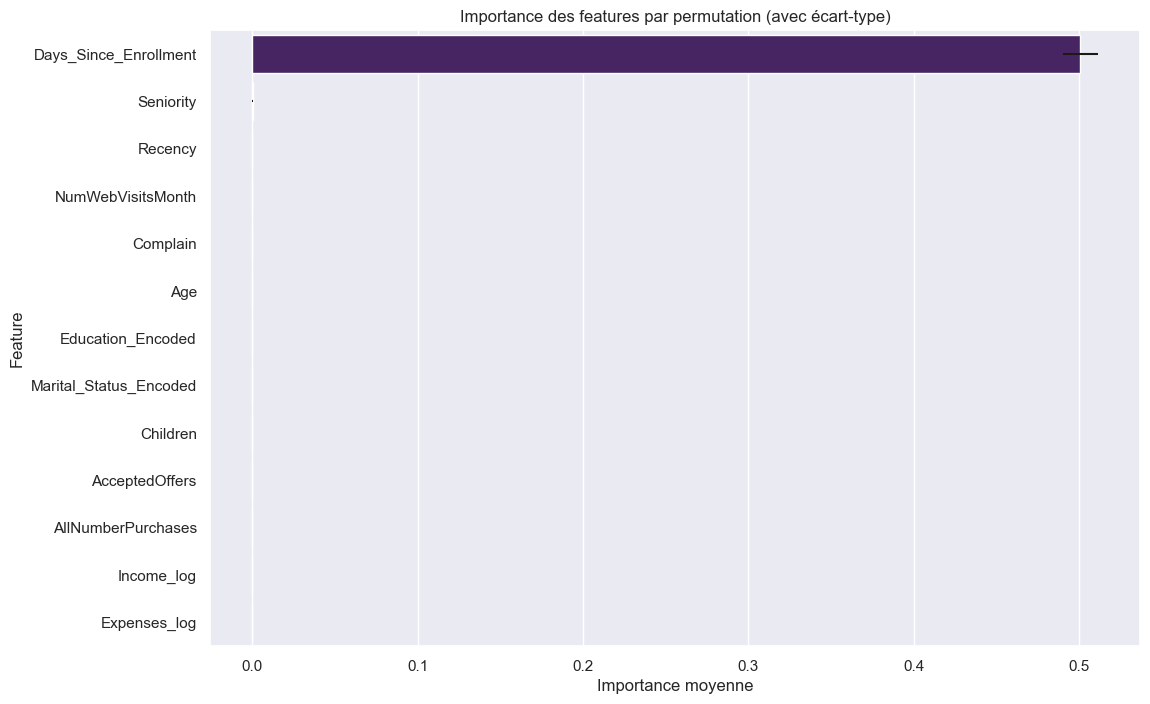

In [63]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculer l'importance des features par permutation
perm_importance = permutation_importance(rf_clf, features, labels, n_repeats=30, random_state=42)

# Extraire la moyenne et l'écart-type des importances pour chaque feature
feature_importance_means = perm_importance.importances_mean
feature_importance_stds = perm_importance.importances_std

# Créer un DataFrame pour afficher les importances
permutation_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance_Mean': feature_importance_means,
    'Importance_STD': feature_importance_stds
}).sort_values(by='Importance_Mean', ascending=False)

# Afficher les importances des features
print(permutation_importance_df)

# Visualiser les importances avec un barplot en utilisant l'écart-type comme "erreur"
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance_Mean', y='Feature', data=permutation_importance_df, palette='viridis', xerr=permutation_importance_df['Importance_STD'])
plt.title("Importance des features par permutation (avec écart-type)")
plt.xlabel("Importance moyenne")
plt.ylabel("Feature")
plt.show()

Q19. On veut maintenant visualiser les données des clients, en indiquant à quel cluster ils appartiennent (typiquement à travers la couleur de leur point).

Il faut donc réduire les données en 2D. Effectuez une PCA avec autant de composantes que les données de départ. Affichez ensuite le ratio de variance expliquée cumulé selon le nombre de composantes considérées.

Vous pourrez utiliser pour cela l'algorithme PCA implémenté dans Scikit-learn : [`sklearn.decomposition.PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

<details>
<summary>Rappel sur le fonctionnement d'une PCA</summary>

Pour rappel, dans une PCA, la 1ère composante est construite de manière à expliquer le plus de variance possible. Ensuite, on transforme les données de manière à ignorer cette composante, et on construit la 2ème composante qui explique le plus de variance (restante) possible. Etc.
Par construction, les composantes sont ordonnées par explication de variance décroissante : prendre la 1ère composante expliquera toujours plus de variance que prendre la 2e, etc.

On peut donc calculer la variance expliquée cumulée en prenant d'abord uniquement la 1ère, puis uniquement la 1ère et la 2ème, puis la 1ère, 2ème, 3ème, etc.

Naturellement, lorsqu'on garde 100% des composantes, on explique ... 100% de la variance.

Dans Sklearn, on peut obtenir le ratio de variance expliquée via un des attributs de l'objet [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (après entraînement)...
</details>

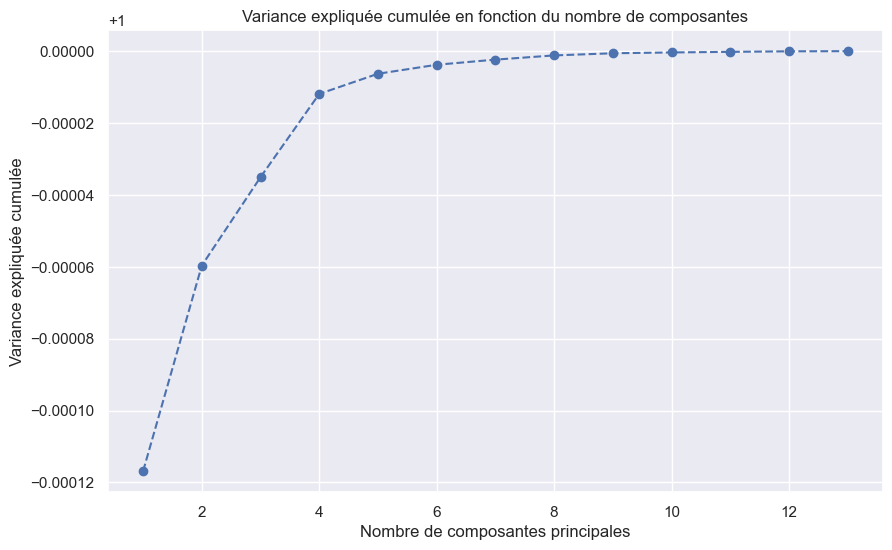

In [64]:
from sklearn.decomposition import PCA

# Effectuer une PCA sur les données des clients (toutes les composantes)
pca = PCA(n_components=len(features.columns))
pca.fit(features)

# Récupérer la variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

# Calculer la variance expliquée cumulée
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Visualiser la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features.columns) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes')
plt.grid(True)
plt.show()


Q20. D'après la courbe obtenue, 2 composantes expliquent-elles suffisamment de variance pour qu'il soit intéressant de visualiser les données ?

Affichez une visualisation en nuage de points (*scatter plot*) en ne retenant que les 2 ou 3 premières composantes (selon votre opinion sur la quantité de variance expliquée), et colorez les points selon leur cluster prédit par KMeans.

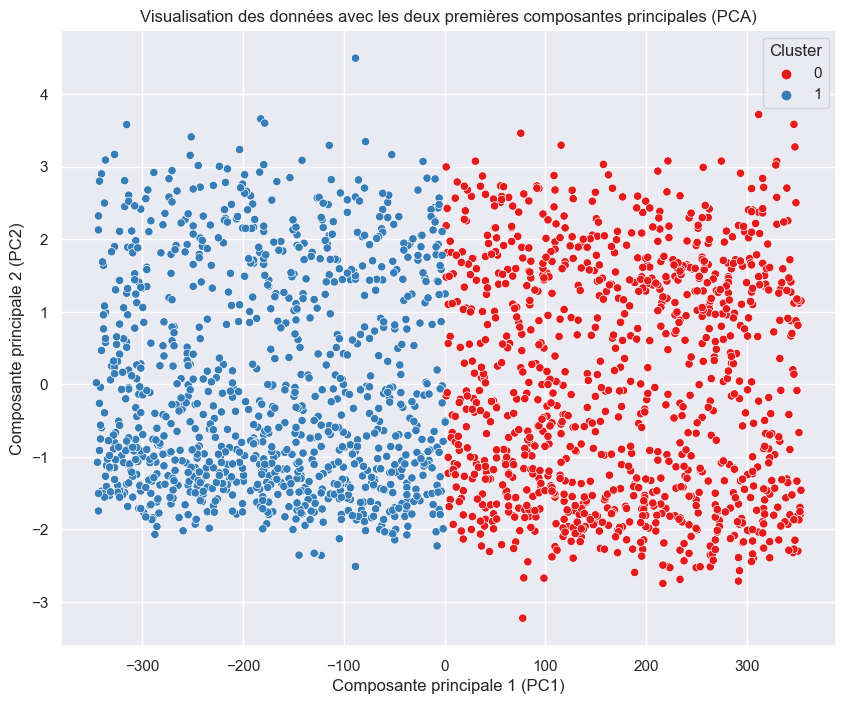

In [65]:
# Réduire les données à 3 composantes à l'aide de PCA
pca_3 = PCA(n_components=3)
pca_components = pca_3.fit_transform(features)

# Créer un DataFrame avec les 3 composantes principales
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])

# Ajouter les clusters du modèle KMeans au DataFrame
pca_df['Cluster'] = labels

# Visualiser les deux premières composantes principales en nuage de points
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1')
plt.title('Visualisation des données avec les deux premières composantes principales (PCA)')
plt.xlabel('Composante principale 1 (PC1)')
plt.ylabel('Composante principale 2 (PC2)')
plt.show()


Cette visualisation permet de voir qu'il existe une frontière de décision linéaire entre les 2 clusters.

En revanche, il est difficile d'interpréter ces données, par rapport aux données d'origine, c'est-à-dire les caractéristiques des clients : la PCA construit une **nouvelle base**. Par exemple, que signifie "1ère composante > 0" ?

Si on veut interpréter les clusters (prédictions), par exemple savoir si le 1er groupe consomme plutôt de la viande, fait beaucoup d'achats, etc., nous avons 2 solutions :

- Interpréter la PCA en "décortiquant" la construction de la nouvelle base. Chaque composante est construite comme une combinaison linéaire des *features* d'origine, on peut donc "lire" la formule pour chaque composante. Par exemple, "1ère composante = 0.37 Income + 0.28 Expenses + 0.000000072 Age + (...)". Cela n'est possible que quand le nombre de *features* d'origine reste faible, ou que les poids de la combinaison linéaire sont négligeables pour de nombreuses *features*. Ici, on a 12 *features*, cela risque d'être compliqué.

- Visualiser les données d'origine. Contrairement à la PCA, ces données-là ne sont pas construites pour expliquer le plus de variance ! On ne peut donc pas se contenter de prendre uniquement les 2 ou 3 premières *features*. Pour interpréter correctement, il vaut mieux regarder la prédiction par rapport à la distribution des données sur chaque colonne. On peut aussi prendre les colonnes 2-à-2 (nuage de point ou *scatter plot*) pour voir s'il existe des relations entre les colonnes. Le calcul d'importance des *features* nous aide à choisir les colonnes sur lesquelles se concentrer : il est inutile de passer trop de temps à analyser visuellement la relation entre `"Complain"` et la prédiction, si en fait `"Complain"` n'était pas utile à la prédiction...

Q21. Analysez la relation entre les dépenses (`"Expenses"`), les revenus (`"Income"`), et la prédiction.

Attention : visualisez les données d'origines, pas les données normalisées ! Sinon, il sera plus difficile d'interpréter (que signifie un `"Income"` de -4 ?). En revanche, il peut être utile d'appliquer des *clippings* si les données sont illisibles car écrasées par des *outliers* très extrêmes.

Que pouvez-vous déduire de ce graphique ?

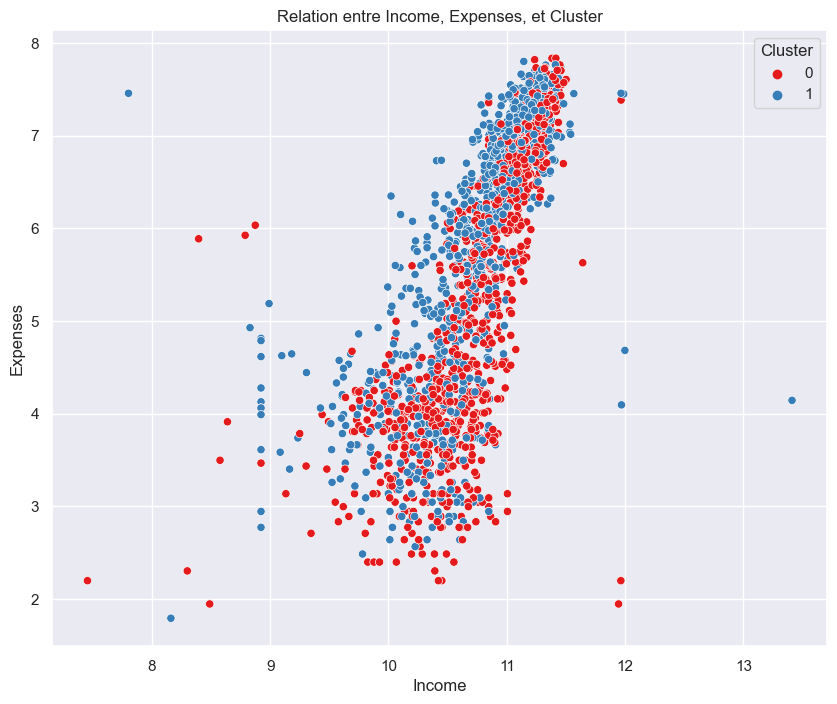

In [81]:
# Création d'un scatter plot pour visualiser la relation entre Expenses, Income et les clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Income_log', y='Expenses_log', hue='Cluster', data=df_customers4, palette='Set1')
plt.title('Relation entre Income, Expenses, et Cluster')
plt.xlabel('Income')
plt.ylabel('Expenses')
plt.show()


Q22. Analysez la relation entre le nombre d'enfants et la prédiction.

Peut-on déduire quelque chose de cette relation ?

In [77]:
### Votre réponse ici

Q23. Analysez la relation entre l'âge et la prédiction.

Que peut-on déduire de cette relation ?

In [78]:
### Votre réponse ici

Q24. Regroupez toutes les informations que vous avez déterminé sur les clusters 0 et 1. Quelle catégorie de population chacun de ces clusters représente ?

Concluez par rapport à la tâche initiale : connaissant les dépenses des clusters 0 et 1, quel(s) plan(s) d'actions l'entreprise peut-elle mettre en œuvre pour augmenter ses bénéfices ?

In [69]:
### Votre réponse ici

## Exercice bonus : imputation de données avec MissForest

Dans cet exercice bonus, nous allons essayer d'imputer les valeurs manquantes de la colonne `"Income"` de manière un peu plus intelligente qu'avec une simple médiane.

Nous allons utiliser l'algorithme [**MissForest**](https://pypi.org/project/MissForest/), qui se base sur les forêts aléatoires.

L'avantage d'un tel algorithme, par rapport à une méthode "fixe" comme la médiane ou la moyenne, est qu'il devrait être capable de détecter les relations entre les variables. Par exemple, supposons qu'il existe une relation entre le revenu (`Income`), et le nombre de produits en or achetés (`MntGoldPurchases`) (cette relation semble assez pertinente), la médiane donnerait le même revenu à tous les individus, peu importe le nombre de produits en or achetés : on risque de supposer que 2 personnes, l'une achetant en moyenne 1 produit en or, et l'autre 10, ont le même revenu !

Quand il existe peu de *features*, et qu'il existe une corrélation claire avec une donnée catégorielle, on peut faire d'abord un `groupby` par rapport à la variable catégorielle, puis imputer par la médiane **de chaque sous-groupe**. C'est déjà un peu plus intéressant que la médiane de l'ensemble des individus, mais ça demande à ce que beaucoup de conditions soient réunies... Dans tous les autre cas, c'est trop complexe à faire à la main, on demande à un algorithme de ML de résoudre le problème pour nous !

Les forêts aléatoires devraient normalement gérer les données catégorielles, mais leur implémentation ne le permet pas, par simplification... Heureusement, nous avons déjà transformé les données catégorielles  :-) (De toute façon, les KMeans non plus n'auraient pas permis d'utiliser des données catégorielles...)

Note : nous allons travailler sur les données **encodées** mais pas besoin qu'elles soient **normalisées**, car les forêts aléatoires sont assez robustes face aux données non-normalisées.

Il vous faudra installer les librairies `missforest` et `lightgbm` :

```sh
pip install missforest lightgbm tqdm
```

Attention ! **MissForest** n'est pas un algorithme parfait, cela reste un algorithme de ML, il est donc sujet au *Garbage In, Garbage Out* !
Pour vérifier que l'algorithme ne fait pas n'importe quoi, nous allons d'abord évaluer sa capacité à imputer des données. Pour cela, on doit agir sur des données que l'on connaît déjà. Nous allons séparer le jeu de données en *training* + *test*, et vérifier que les imputations sur les données de test (connues mais non apprises !) sont cohérentes, c'est-à-dire pas trop éloignées de la véritable donnée...

Q1. Séparez les données (connues donc non-NA !) en *training* (80%) + *test* (20%), à partir des données encodées mais non normalisées.

(Si vous avez utilisé les bons noms de variables, ce devrait être votre `df_customers2`.)

In [70]:
### Votre réponse ici

Q2. Apprenez un modèle [**MissForest**](https://pypi.org/project/MissForest/) à partir des données d'entraînement.

<details>
<summary>Astuce</summary>

**MissForest** essaie de suivre les mêmes conventions que Scikit-learn pour les noms et signatures de méthode : cela fournit une API un peu standard que l'on peut utiliser quelque soit le modèle sous-jacent. Si vous ne vous souvenez pas de quelle méthode on se sert pour **entraîner** (pas prédire !), vous pouvez toujours regarder leurs [exemples](https://pypi.org/project/MissForest/).
</details>

In [71]:
### Votre réponse ici

Q3. Remplacez 5% des valeurs d'`"Income"` par des NA dans les données de test, tout en retenant les valeurs originelles ! (nous en aurons besoin)

Vous pourrez utiliser `np.nan` comme valeur de NA.

<details>
<summary>Astuce</summary>

En combinant les fonctionnalités de NumPy et de Pandas, on peut arriver à une solution assez facile à ce problème.

On veut d'abord générer les indices des lignes à sélectionner : il s'agit de faire $\frac{5}{100}N$ choix parmi $N$ pour en obtenir 5%. La méthode [`np.random.choice()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) pourra vous être utile.

Puis, on veut récupérer les valeurs du DataFrame dont les lignes correspondent à ces indices. L'attribut [`df.loc[lines, columns]`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) de Pandas sert à accéder à des données par rapport aux "noms" (pour une ligne, il s'agit de son index, ici un numéro, et pour les colonnes, du nom de la colonne). `loc` peut être utilisé pour indexer plusieurs valeurs en même temps : `df.loc[[1, 2, 17], 'Bidule']` récupère la valeur de la colonne `'Bidule'` des lignes `1`, `2`, et `17`.

Enfin, pour remplacer ces valeurs par des NA, notez que `df.loc` peut être utilisé en lecture comme en écriture...
</details>

In [72]:
### Votre réponse ici

Q4. Imputez ces valeurs aux données de test (prédictions) en appliquant le modèle aux données de test.

<details>
<summary>Astuce</summary>

Là encore, **MissForest** suit la même convention que Scikit-learn : quelle méthode peut-on utiliser pour prédire des données à partir d'un jeu de données de test ?
</details>

In [73]:
test_predictions = mf.transform(df_customers2_test)

NameError: name 'mf' is not defined

Q5. Calculez la loss entre les prédictions et les données réellement connues de test.

On va utiliser une loss *Mean Absolute Percentage Error*, car les données `"Income"` sont assez grandes.
Une MSE donnerait donc des valeurs difficiles à interpréter : par exemple, si le modèle se trompe de 1000 USD dans sa prédiction, cela donnerait une erreur de $1000^2 = 1 000 000$. Une MAE évite cette "explosion" des erreurs, mais resterait difficile à interpréter : une erreur de 1000 USD n'a pas le même impact selon que le salaire à prédire était de 3000 USD ou de 120 000 USD !

La MAPE est similaire à la MAE, sauf que l'on divise l'erreur par la valeur à prédire :

$$
MAPE = \frac{1}{n} \sum_{i=1}^{n} | \frac{y_i - \hat{y_i}}{y_i}|
$$

(Traditionnellement, on multiplie le résultat obtenu par 100 pour obtenir un pourcentage au lieu d'un ratio entre 0 et 1)

In [ ]:
### Votre réponse ici

Vous devriez obtenir une erreur un peu élevée mais correcte, surtout que nous avons demandé à imputer 5% des valeurs dans les données de test. Dans le jeu de données complet, nous n'aurons que très peu de données à imputer, le risque d'erreur sera donc moins grand !

Nous avons donc vérifié la faisabilité en pratique de **MissForest** sur ce jeu de données.

Q6. Utiliser **MissForest** pour imputer les données dans un DataFrame `df_customers3`, à partir des données d'origine (on ignore maintenant *train* et *test* que nous n'avions construit que pour évaluer la faisabilité).

Note : vous devriez re-créer et re-entraîner un modèle "depuis 0".

In [ ]:
### Votre réponse ici